In [1]:
import os
from os.path import join
import glob
from itertools import compress
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt
import logging

# helper functions
from importlib import reload
import model_utils
import viz_utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# create logging to file
logdir = join("logfiles")
logger = logging.getLogger("scnn")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(join(logdir, "scnn.log"), mode='a')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s, %(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

features = ['precip', 'elevation', 'deltares', 'jrc_permwa', 'soiltemp2',
       'soiltemp2_anom', 'evi_anom', 'aqueduct', 'exclusion_mask', 'mangrove',
       'soilcarbon', 'pressure_min', 'pressure_avg',
       'evi', 'wind_avg', 'wind_max']

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')
resultsdir = join(wd, 'results')

In [2]:
# load the GeoDataFrame
reload(model_utils)
gdf_orig = model_utils.load_spatial_data(wd)  # load gdfs with all features as one big gdf
gdf = gdf_orig.copy(deep=True)  # keep copy in case gdf gets messed up

print("Number of unique images (i.e., subregions):", gdf['event'].nunique())

Number of unique images (i.e., subregions): 59


In [3]:
gdf = gdf[features + ['geometry', 'floodfrac', 'event']]
gdf = gdf.dropna()

In [4]:
# calculate quantities of data for loss function
n = len(gdf)
n1 = gdf['floodfrac'].sum()
n0 = n - n1
print("Zeros:", n0)
print("Ones:", n1)
print(f"Null values: {sum(gdf.isnull().any())}")

Zeros: 216800
Ones: 24800
Null values: 0


In [5]:
# reformat into numpy arrays for tensorflow
Xmats = []
ymats = []

# now calculate X and y matrices
for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat, feature_key = model_utils.get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)
        
feature_key_r = {item: key for key, item in feature_key.items()}

# calculate weights and flatten labels matrix
ymats_bool = [mat.astype(bool) for mat in ymats]
ymats_flat = [mat.flatten() for mat in ymats]
ymats_flat = [np.expand_dims(mat, -1) for mat in ymats_flat]

In [6]:
# create TensorFlow datasets with batch size 1 (since small dataset)
n = len(Xmats)
ntrain = int(0.6 * n)
ntest = int(0.2 * n)

# create dataset
data = tf.data.Dataset.from_tensor_slices((Xmats, ymats_flat)).batch(1)
train = data.take(ntrain)
test = data.skip(ntrain)
valid = test.skip(ntest)
test = test.take(ntest)

# extract matrices from train for visualisation later
X_train = [element[0].numpy()[0, :, :, :] for element in train]
X_valid = [element[0].numpy()[0, :, :, :] for element in valid]
X_test = [element[0].numpy()[0, :, :, :] for element in test]

y_train = [element[1].numpy()[0, :] for element in train]
y_valid = [element[1].numpy()[0, :] for element in valid]
y_test = [element[1].numpy()[0, :] for element in test]

print("Dataset size:", n)
print("Training size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))

Dataset size: 59
Training size: 35
Validation size: 13
Test size: 11


### Weighting options

In [7]:
def add_sample_weights(image, label):
    """Add sample weights."""
    class_weights = tf.constant(weights_list)  # global var
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

def add_pw_weights(image, label):
    """Add weights for permanent water."""
    class_weights = tf.constant([0.0, 1.0])
    pw = image[0, :, :, 1]
    pw = tf.reshape(pw, [1, 64 * 64, 1])
    land_mask = pw < 50
    sample_weights = tf.gather(class_weights, indices=tf.cast(land_mask, tf.int32))
    return image, label, sample_weights

def add_both_weights(image, label):
    """Add both sample and permanent water weights."""
    class_weights = tf.constant(weights_list)  # global var

    # create a permanent water mask (assuming pw feature in channel 1)
    pw = image[0, :, :, 1]
    pw = tf.reshape(pw, [1, 64 * 64, 1])
    land_mask = pw < 50
    land_mask = tf.cast(land_mask, dtype=tf.float32)
    
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    sample_weights *= land_mask

    return image, label, sample_weights

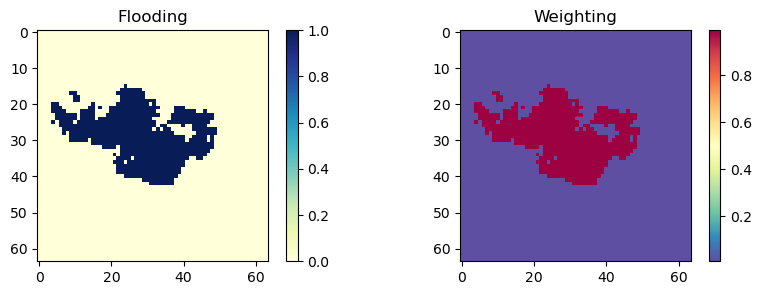

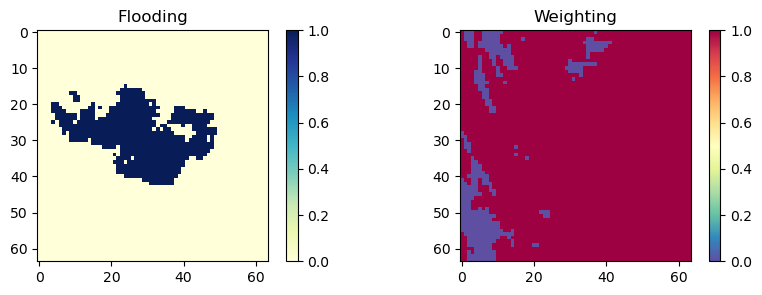

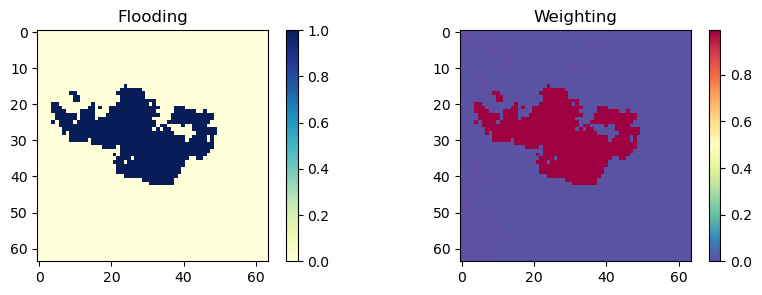

In [8]:
viz = True

global weights_list
weights_list = [0.01, 0.99]

if viz:
    # sample weights
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_sample_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])
    
    
    # permanent water weights
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_pw_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])
    
    # both weights
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_both_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])

### Visualise train and test sets

In [9]:
vmins = []
vmaxs = []
for feature in features:
    vmins.append(gdf[feature].min())
    vmaxs.append(gdf[feature].max())

In [10]:
# view training set
viz = False

if viz:
    fig, ax = plt.subplots(nfeatures+1, len(y_train), figsize=(2 * len(y_train), 2 * nfeatures + 1))
    for i, im in enumerate(y_train):
        pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
        ax[0, 0].set_title(f"Flood Fraction")
    fig.colorbar(pos, ax=ax[0, len(y_train)-1])
        
    for fi in range(nfeatures):
        for i, im in enumerate(X_train):
            pos = ax[fi+1, i].imshow(im[:, :, fi], cmap=feature_cmaps[fi], vmin=vmins[fi], vmax=vmaxs[fi])
            ax[fi+1, 0].set_title(features[fi].capitalize())
        fig.colorbar(pos, ax=ax[fi+1, len(y_train)-1])

    plt.savefig(join(imdir, "trainingset_binary.png"), bbox_inches="tight")

In [11]:
# view testing set
viz = False

if viz:
        nfeatures = len(features)
        fig, ax = plt.subplots(nfeatures+1, len(y_test), figsize=(2 * len(y_test), 2 * nfeatures + 1))
        for i, im in enumerate(y_test):
            pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
            ax[0, i].set_xticks([])
            ax[0, i].set_yticks([])
            ax[0, 0].set_title(f"Flood Fraction")
        # fig.colorbar(pos, ax=ax[0, len(y_test)-1])

        for fi in range(nfeatures):
            for i, im in enumerate(X_test):
                pos = ax[fi+1, i].imshow(im[:, :, fi], cmap=feature_cmaps[fi]) # , vmin=vmins[fi], vmax=vmaxs[fi])
                ax[fi+1, 0].set_title(features[fi].capitalize())
                ax[fi+1, 0].set_xticks([])
                ax[fi+1, 0].set_yticks([])
            # fig.colorbar(pos, ax=ax[fi+1, len(y_test)-1])

        #plt.savefig(join(imdir, "testingset_binary.png"), bbox_inches="tight")

### SCNN
Can either use:
1. A `BinaryCrossentropy` loss with the sigmoid activation function and no one-hot encoding. This requires the array to be flattened to shape ($x\times y$, nchannels).
2. A `SparseCategoricalCrossentropy` loss with a softmax activation function and one-hot encoding on the predictions only (i.e., labels are never one-hot encoded). This doesn't require the array to be flattened.

For model calibration, it may be preferable to use a bias measure instead since this would determine what parameter set provides the balance between over and underprediction, but while there may be binary pattern performance measures that do not show bias to either under or over prediction, they will still be affected by the magnitude effect mentioned below (Stephens 2014).

#### Model improvements:
1. [ ] Tuning: dilation_rate, optimiser, weight_dry, decay_rate, learning_rate
2. [x] Loss function (needs some reviewing)
3. [x] Metrics



CSI (smooth)
 Note that the `50` value in the `sigmoid` function can be adjusted to control the "smoothness" of the rounding. Higher values will result in sharper transitions between 0 and 1, while lower values will result in smoother transitions.

The `backend.sigmoid()` function is used to create a smooth transition between 0 and 1. In this case, the `sigmoid()` function is used to "round" the values to 0 or 1 in a differentiable way, which is required for the loss function to be differentiable.

The expression `50 * (y_true * y_pred - 0.5)` is used to "center" the values around 0.5, so that the sigmoid function outputs values close to 0 or 1 when `y_true * y_pred` is close to 1 (i.e. when the prediction is correct). The value `50` is a hyperparameter that can be adjusted to control the "smoothness" of the transition between 0 and 1. Higher values will result in sharper transitions, while lower values will result in smoother transitions.

The expressions `50 * ((1 - y_true) * y_pred - 0.5)` and `50 * (y_true * (1 - y_pred) - 0.5)` are used to calculate the false positives and false negatives, respectively. The `1 - y_true` expression is used to invert the target values (i.e. 1 becomes 0 and 0 becomes 1), so that the false positives and false negatives can be calculated correctly.
    

In [12]:
# https://stackoverflow.com/questions/64805255/customized-loss-function-in-keras-iou-loss-function-and-gradient-error 
from keras import backend as K

def smooth_csi(y_true, y_pred):
    """
    The 50 value is a smoothness parameter. A higher value 
    will result in sharper transitions between 0 and 1, while lower values result in slower transitions. The 
    0.5 is used to center the values around 0.5.
    """

    # Calculate the true positives, false positives, and false negatives
    true_positives = K.sum(K.sigmoid(50 * (y_true * y_pred - 0.5)))
    false_positives = K.sum(tf.keras.backend.sigmoid(50 * ((1 - y_true) * y_pred - 0.5)))
    false_negatives = K.sum(tf.keras.backend.sigmoid(50 * (y_true * (1 - y_pred) - 0.5)))

    # Calculate the CSI
    csi = true_positives / (true_positives + false_negatives + false_positives)

    # Return the negative of the CSI as the loss (since we want to minimize the loss)
    return -csi


def custom_csi(y_true, y_pred):
    """
    Note that the `50` value in the `sigmoid` function can be adjusted to control the "smoothness" of the rounding. Higher values will result in sharper transitions between 0 and 1, while lower values will result in smoother transitions.

    The `backend.sigmoid()` function is used to create a smooth transition between 0 and 1. In this case, the `sigmoid()` function is used to "round" the values to 0 or 1 in a differentiable way, which is required for the loss function to be differentiable.

    The expression `50 * (y_true * y_pred - 0.5)` is used to "center" the values around 0.5, so that the sigmoid function outputs values close to 0 or 1 when `y_true * y_pred` is close to 1 (i.e. when the prediction is correct). The value `50` is a hyperparameter that can be adjusted to control the "smoothness" of the transition between 0 and 1. Higher values will result in sharper transitions, while lower values will result in smoother transitions.

    The expressions `50 * ((1 - y_true) * y_pred - 0.5)` and `50 * (y_true * (1 - y_pred) - 0.5)` are used to calculate the false positives and false negatives, respectively. The `1 - y_true` expression is used to invert the target values (i.e. 1 becomes 0 and 0 becomes 1), so that the false positives and false negatives can be calculated correctly.
    """

    # create vector of falses
    y_false = 1 - y_true
    
    
    # Calculate the true positives, false positives, and false negatives
    true_positives = K.sum(y_true * y_pred)
    false_positives = K.sum(y_false * y_pred)
    false_negatives = K.sum(y_true * (1 - y_pred))

    # Calculate the CSI
    csi = true_positives / (true_positives + false_negatives + false_positives)

    # Return the negative of the CSI as the loss (since we want to minimize the loss)
    return - csi

In [16]:
%load_ext tensorboard

import tensorflow as tf
import datetime
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Reshape
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU, Recall
from tensorflow.keras import Model
from keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from keras import backend as K

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

TP = tf.keras.metrics.TruePositives(name="TP")
TN = tf.keras.metrics.TrueNegatives(name="TN")
FP = tf.keras.metrics.FalsePositives(name="FP")
FN = tf.keras.metrics.FalseNegatives(name="FN")
CSI = tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5, name="CSI")


# settings
k_init = "he_normal"
dilation_rate = (35, 35)  # (80, 80) => see shape of water in probs, [2, 5, 10, 25, 50], (35, 35) gets high values
weight_dry = 0.05  # [0.01, 0.02, 0.05, 0.1, 0.2]
weights_list = [weight_dry, 1 - weight_dry]
weight_func =  add_sample_weights # [add_sample_weights, add_pw_weights, and add_both_weights]
optimizer = Adam()  # SGD(1e-3)  # [Adam(), SGD()]
loss_fn = custom_csi # [BinaryCrossentropy(), custom_csi_loss, BinaryIoU_loss] 
metrics = [CSI, BinaryAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]
epochs = 40
patience = 5

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


custom iou loss: https://arxiv.org/pdf/1608.01471.pdf <br>
custom losses: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss <br>
https://www.tensorflow.org/tutorials/distribute/custom_training <br>
https://discuss.pytorch.org/t/custom-loss-function-iou-is-not-differentiable-can-you-create-a-differentiable-iou-loss-function-for-ml/148899 <br>

In [17]:
# with GradientTape
if False:
    SEED = 1
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    def build_scnn(shape=(128, 128, 3), k_init="he_normal", dilation_rate=(1, 1), dtype=tf.float32):
        inputs = Input(shape=shape)
        normalized = BatchNormalization(axis=3)(inputs)

        x = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=k_init)(normalized)
        x = Conv2D(128, 3, padding="same", activation="relu", dilation_rate=dilation_rate, kernel_initializer=k_init)(x)
        x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)

        outputs = Conv2D(1, 1, padding="same", activation="sigmoid", dtype=dtype)(x)
        outputs = Reshape((64 * 64, 1))(outputs)
        scnn = Model(inputs, outputs, name="SCNN")
        return scnn

    scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)),
                      k_init=k_init,
                      dilation_rate=dilation_rate)

    @tf.function
    def train_step(x, y):
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            tape.watch(scnn.trainable_variables)
            y_pred = scnn(x, training=True)
            loss = loss_fn(y, y_pred)
        gradients = tape.gradient(loss, scnn.trainable_variables)  # differentiate loss wrt scnn weights
        print(f"gradients: {gradients}")
        optimizer.apply_gradients(zip(gradients, scnn.trainable_variables))
        return loss, y_pred

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_csi = 0
        epoch_accuracy = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_auc = 0
        num_batches = 0
        for x, y, w in train.map(weight_func):
            y = tf.cast(y, dtype=tf.float32)
            loss, y_pred = train_step(x, y)
            epoch_loss += loss
            epoch_csi += metrics[0](y, y_pred)
            epoch_accuracy += metrics[1](y, y_pred)
            epoch_precision += metrics[2](y, y_pred)
            epoch_recall += metrics[3](y, y_pred)
            epoch_auc += metrics[4](y, y_pred)
            num_batches += 1

        epoch_loss /= num_batches
        epoch_csi /= num_batches
        epoch_accuracy /= num_batches
        epoch_precision /= num_batches
        epoch_recall /= num_batches
        epoch_auc /= num_batches
        print("Epoch {0}/{1}: Loss={2:.4f}, CSI={3:.4f}, Accuracy={4:.4f}, Precision={5:.4f}, Recall={6:.4f}, AUC={7:.4f}".format(epoch+1, epochs, epoch_loss, epoch_csi, epoch_accuracy, epoch_precision, epoch_recall, epoch_auc))

    y_probs = []
    for x, y in test:
        y_pred = scnn(x, training=False)
        y_probs.append(y_pred)
    y_probs = np.concatenate(y_probs, axis=0)
    y_pred = (y_probs > 0.5).astype(float)


In [32]:
# without GradientTape
if True:
    SEED = 1
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    def build_scnn(shape=(128, 128, 3), k_init="he_normal", dilation_rate=(1, 1)):
        inputs = Input(shape=shape)
        normalized = BatchNormalization(axis=3)(inputs)

        x = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=k_init)(normalized)
        x = Conv2D(128, 3, padding="same", activation="relu", dilation_rate=dilation_rate, kernel_initializer=k_init)(x)
        x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)

        outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
        outputs = Reshape((64 * 64, 1))(outputs)
        scnn = Model(inputs, outputs, name="SCNN")
        return scnn

    scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)),
                      k_init=k_init,
                      dilation_rate=dilation_rate)
    # scnn.summary()

    scnn.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics)

    history = scnn.fit(train.map(weight_func),
                       epochs=epochs,
                       verbose=0,  # suppress chatty output, use Tensorboard instead
                       validation_data=valid,
                       callbacks=[EarlyStopping(patience=patience),tensorboard_callback])

In [19]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 1228), started 0:07:50 ago. (Use '!kill 1228' to kill it.)

In [23]:
if False:
    reload(model_utils)
    im = model_utils.plot_history(history, metric='loss')
    plt.savefig(join(imdir, "scnn_training_loss.png"), bbox_inches="tight")


    im = model_utils.plot_history(history, metric='CSI')
    plt.savefig(join(imdir, "scnn_training_csi.png"), bbox_inches="tight")

In [87]:
y_probs = scnn.predict(test)
y_pred = (y_probs > 0.5).astype(float)

CSI.update_state(y_test, y_probs)
TP.update_state(y_test, y_probs)
FP.update_state(y_test, y_probs)
FN.update_state(y_test, y_probs)
TN.update_state(y_test, y_probs)

csi = CSI.result().numpy()
tp = TP.result().numpy()
fp = FP.result().numpy()
fn = FN.result().numpy()
tn = TN.result().numpy()

# assert 4096 * len(y_test) == tp + tn + fp + fn  # ????

print(f"CSI: {csi*100:.2f}%")
print(f"TP: {tp:.0f}")
print(f"FP: {fp:.0f}")
print(f"FN: {fn:.0f}")
print(f"TN: {tn:.0f}")

print(f"Bias: {(tp + fp) / (tp + fn) :.2f}")  # small=>underprediction
print(f"Hit rate: {tp /(tp + fn):.2f}")
print(f"False alarm rate: {fp / (fp + tn):.2f}")
print(f"F<3>: {(tp - fn) / (tp + fp + fn):.2f}")

11/11 [==============================] - 0s 10ms/step
CSI: 9.25%
TP: 6250
FP: 38806
FN: 0
TN: 0
Bias: 7.21
Hit rate: 1.00
False alarm rate: 1.00
F<3>: 0.14


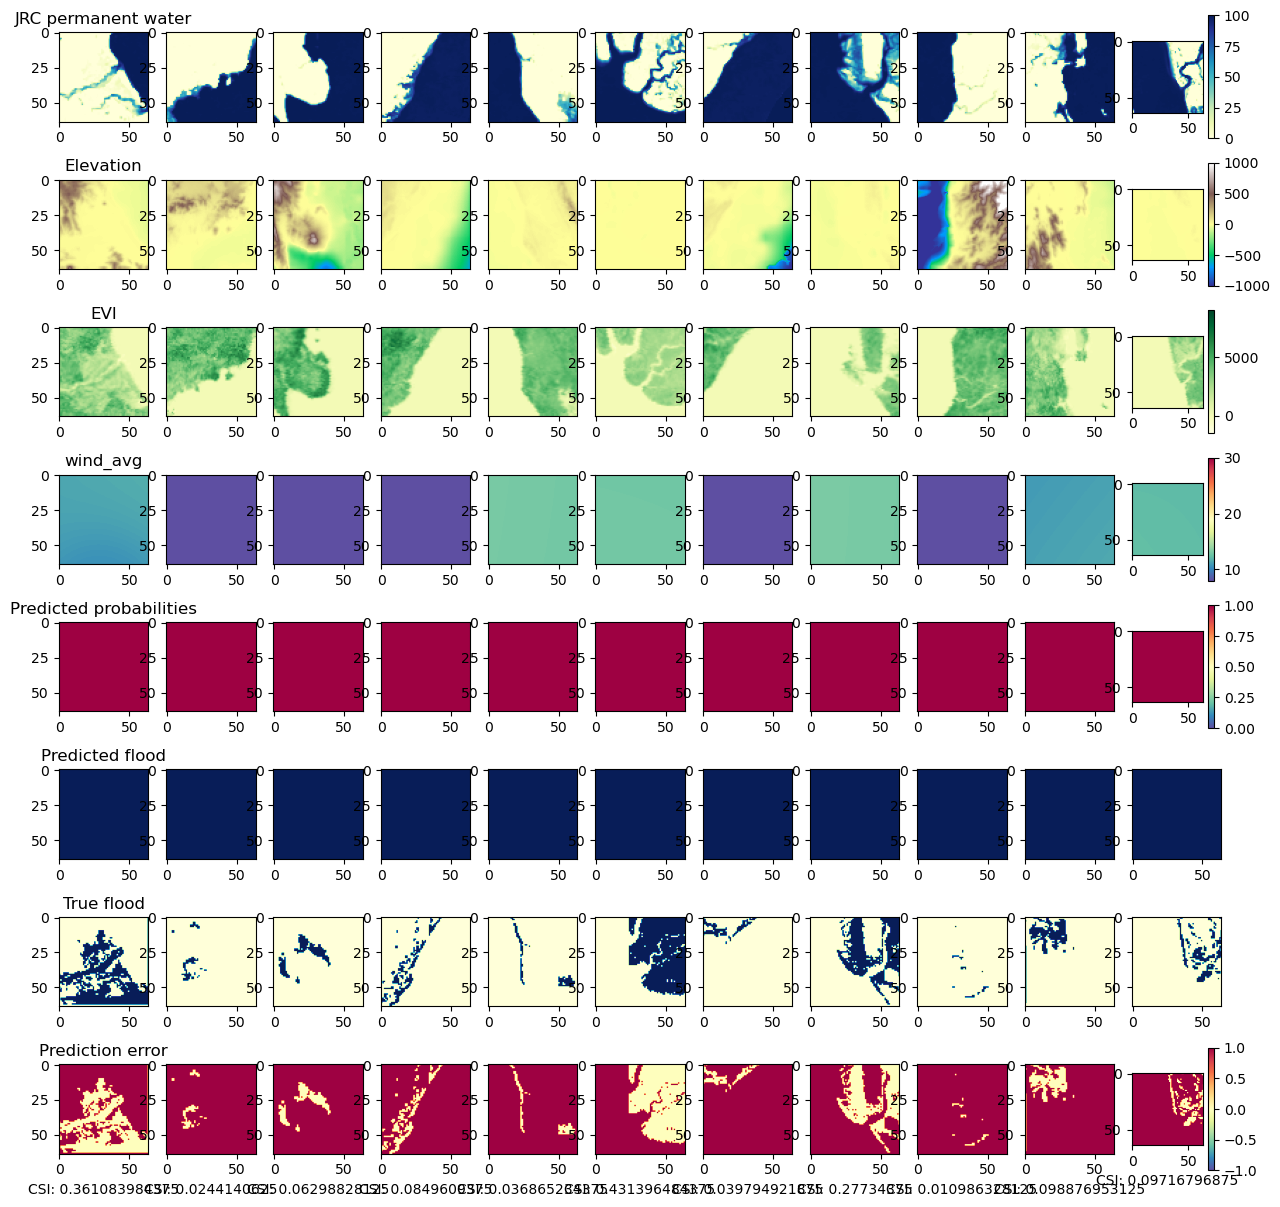

In [88]:
# plot results on the test set
viz = True

if viz:
    fig, axs = plt.subplots(8, len(X_test), figsize=(15, 15))

    ax = axs[0, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['jrc_permwa']
        cmap, _, _ = viz_utils.cmap_key['jrc_permwa']
        vmin, vmax = viz_utils.cmap_range['jrc_permwa']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("JRC permanent water")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[1, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['elevation']
        cmap, _, _ = viz_utils.cmap_key['elevation']
        vmin, vmax = viz_utils.cmap_range['elevation']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("Elevation")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[2, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['evi']
        cmap, _, _ = viz_utils.cmap_key['evi']
        vmin, vmax = viz_utils.cmap_range['evi']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("EVI")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    
    ax = axs[3, :]
    for i, pred in enumerate(X_test):
        wind_var = 'wind_avg'
        fi = feature_key_r[wind_var]
        cmap, _, _ = viz_utils.cmap_key[wind_var]
        vmin, vmax = viz_utils.cmap_range[wind_var]
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title(wind_var)
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[4, :]
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r", vmin=0, vmax=1)
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[5, :]
    for i, pred in enumerate(y_pred):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=1)
    ax[0].set_title("Predicted flood")
        
    ax = axs[6, :]
    for i, pred in enumerate(y_test):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=1)
    ax[0].set_title("True flood")
    
    ax = axs[7, :]
    for i, x in enumerate(zip(y_pred, y_test)):
        pred, true = x[0], x[1]
        CSI.reset_state()
        CSI.update_state(true, pred)
        csi_i = CSI.result().numpy()
        
        err = (pred.reshape(64, 64) == true.reshape(64, 64)).astype(float)
        diff = pred.reshape(64, 64) - true.reshape(64, 64)
        
        im = ax[i].imshow(diff, cmap="Spectral_r", vmin=-1, vmax=1)
        ax[i].set_xlabel(f"CSI: {csi_i}")
    ax[0].set_title("Prediction error")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    outfile = join(imdir, "scnn", "scnn_results.png")
                     
    # fig.savefig(outfile, bbox_inches="tight")

In [89]:
!say done

In [107]:
# log results
logger.info("NEW RUN")
logger.info(f"Loading data with:\ntemporal={temporal},\nbinary={binary},\nstorm subset: {storm}")
logger.info(f"Run with {nfeatures} features: {features}")
logger.info(f"Number of unique images/subregions: {n}")
logger.info(f"Zeros: {n0}")
logger.info(f"Ones: {n1}")


logger.info(f"Training size: {len(X_train)}")
logger.info(f"Validation size: {len(X_valid)}")
logger.info(f"Test size: {len(X_test)}\n")


logger.info("SCNN SETTINGS")
logger.info(f"Kernel initializer: {k_init}")
logger.info(f"Dilation rate: {dilation_rate}")
logger.info(f"Dry weight: {weights_list[0]}, Wet weight: {weights_list[1]}")
logger.info(f"Weighting function: {weight_func}")
logger.info(f"Optimizer: {optimizer}")
logger.info(f"Loss function: {loss.name}")
logger.info(f"Random seed: {SEED}")
logger.info(f"Number of training epochs: {epochs}")
logger.info(f"Early stopping patience: {patience}\n")

logger.info("RESULTS")
logger.info(f"CSI: {csi * 100:.2f}%")
logger.info(f"TP: {tp:.0f}")
logger.info(f"FP: {fp:.0f}")
logger.info(f"FN: {fn:.0f}")
logger.info(f"TN: {tn:.0f}")

logger.info(f"Bias: {(tp + fp) / (tp + fn) :.2f}")  # small=>underprediction
logger.info(f"Hit rate: {tp /(tp + fn):.2f}")
logger.info(f"False alarm rate: {fp / (fp + tn):.2f}")
logger.info(f"F<3>: {(tp - fn) / (tp + fp + fn):.2f}")

logger.info("END OF RUN\n\n\n")

# U-Net
## _Needs tidying to be same as SCNN above_
[Keras implementation from here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)

In [51]:
# define the U-Net architecture
def double_conv_block(x, depth, k_init):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    return x

def downsample_block(x, depth, k_init):
    f = double_conv_block(x, depth, k_init)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth, k_init):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth, k_init)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3), k_init="he_normal"):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    # encoder
    f1, p1 = downsample_block(normalized, 64, k_init)
    f2, p2 = downsample_block(p1, 128, k_init)
    f3, p3 = downsample_block(p2, 256, k_init)
    f4, p4 = downsample_block(p3, 512, k_init)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024, k_init)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512, k_init)
    u7 = upsample_block(u6, f3, 256, k_init)
    u8 = upsample_block(u7, f2, 128, k_init)
    u9 = upsample_block(u8, f1, 64, k_init)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    outputs = Reshape((64*64, 1))(outputs)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

In [54]:
unet = build_unet(shape=(64, 64, len(features)), k_init="he_normal")

unet.compile(optimizer=optimizer,
             loss=loss_fn,  # BinaryCrossentropy(from_logits=True),
             metrics=metrics,
             weighted_metrics=['accuracy', 'Recall', 'Precision'],
             sample_weight_mode='temporal')

history = unet.fit(train.map(add_sample_weights),
                   epochs=40,
                   validation_data=valid,
                   callbacks=EarlyStopping(patience=3))

model_utils.plot_history(history, metric='loss')             

Epoch 1/40
35/35 [==============================] - 6s 136ms/step - loss: -0.0272 - CSI: 0.0937 - accuracy: 0.1023 - precision: 0.0938 - recall: 0.9835 - auc: 0.4927 - weighted_accuracy: 0.6910 - weighted_recall: 0.9804 - weighted_precision: 0.6993 - val_loss: -0.0535 - val_CSI: 0.0535 - val_accuracy: 0.0535 - val_precision: 0.0535 - val_recall: 1.0000 - val_auc: 0.5000 - val_weighted_accuracy: 0.0535 - val_weighted_recall: 1.0000 - val_weighted_precision: 0.0535
Epoch 2/40
35/35 [==============================] - 4s 123ms/step - loss: -0.0273 - CSI: 0.1095 - accuracy: 0.1095 - precision: 0.1095 - recall: 1.0000 - auc: 0.5000 - weighted_accuracy: 0.7003 - weighted_recall: 1.0000 - weighted_precision: 0.7003 - val_loss: -0.0535 - val_CSI: 0.0535 - val_accuracy: 0.0535 - val_precision: 0.0535 - val_recall: 1.0000 - val_auc: 0.5000 - val_weighted_accuracy: 0.0535 - val_weighted_recall: 1.0000 - val_weighted_precision: 0.0535
Epoch 3/40
35/35 [==============================] - 4s 129ms/ste

NameError: name 'plot_history' is not defined


Testing set root mean squared error: 0.14
11/11 [==============================] - 0s 33ms/step


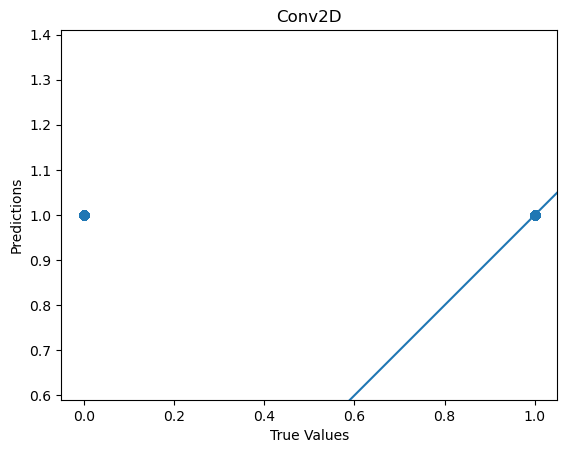

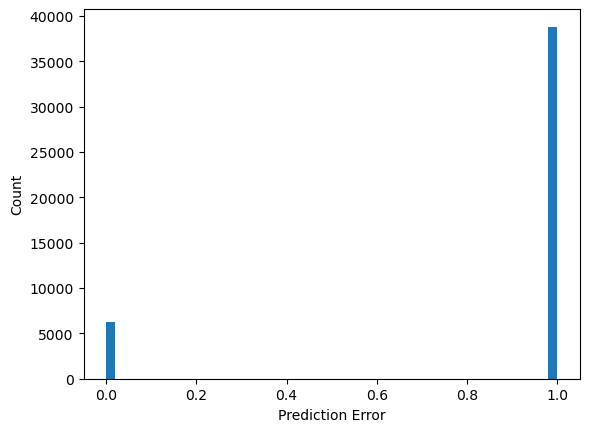

In [56]:
[loss, rmse] = unet.evaluate(test, verbose=0)[:2]
print("\nTesting set root mean squared error: {:4.2f}".format(rmse))

y_probs = unet.predict(test)
y_pred = (y_probs > 0.5).astype(float)

model_utils.plot_prediction(np.array(y_test).flatten(), y_probs.flatten(), "Conv2D")

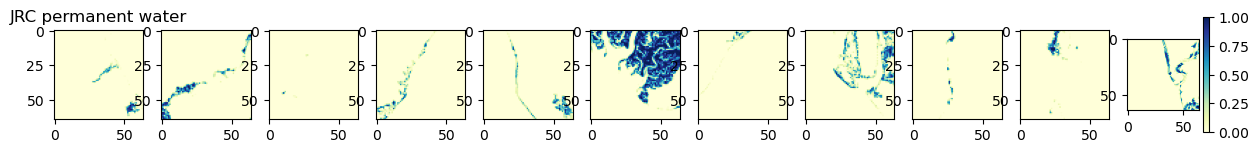

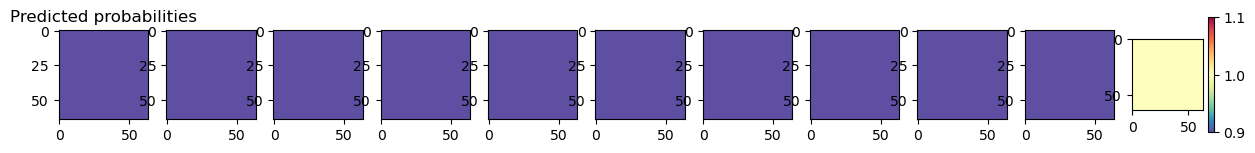

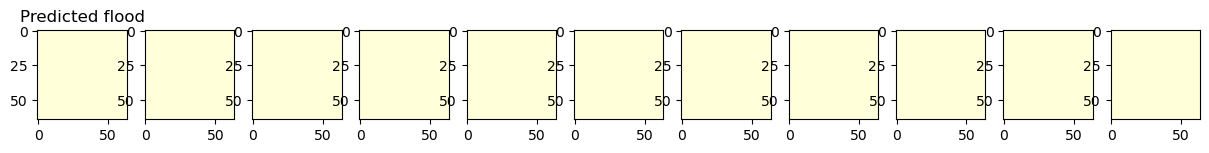

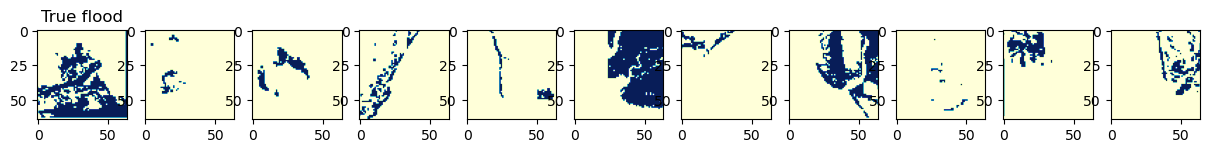

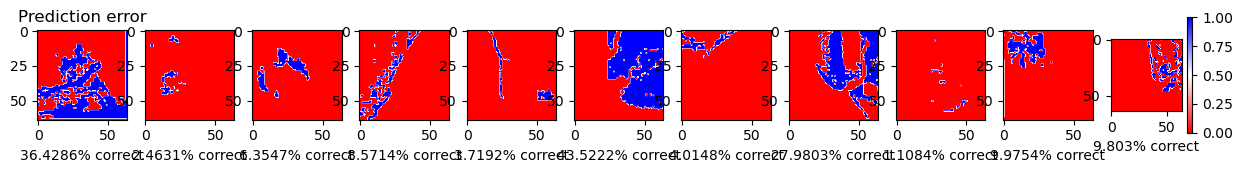

In [57]:
if viz:
    fig, ax = plt.subplots(1, len(X_test), figsize=(15, 1.5))
    for i, pred in enumerate(X_test):
        im = ax[i].imshow(pred[:, :, 2], cmap="YlGnBu")
    ax[0].set_title("JRC permanent water")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    fig, ax = plt.subplots(1, len(y_probs), figsize=(15, 1.5))
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r")
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    fig, ax = plt.subplots(1, len(y_pred), figsize=(15, 1.5))
    for i, pred in enumerate(y_pred):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu")
    ax[0].set_title("Predicted flood")
        
    fig, ax = plt.subplots(1, len(y_test), figsize=(15, 1.5))
    for i, pred in enumerate(y_test):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu")
    ax[0].set_title("True flood")
    
    fig, ax = plt.subplots(1, len(y_pred), figsize=(15, 1.5))
    for i, x in enumerate(zip(y_pred, y_test)):
        pred, true = x[0], x[1]
        err = (pred.reshape(64, 64)==true.reshape(64, 64)).astype(float)
        im = ax[i].imshow(err, cmap="bwr_r")
        ax[i].set_xlabel(f"{np.round(100 * err.sum() / 4060, 4)}% correct")
    ax[0].set_title("Prediction error")
    
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    # plt.savefig(join(wd, "unet_results.png"), bbox_inches="tight")

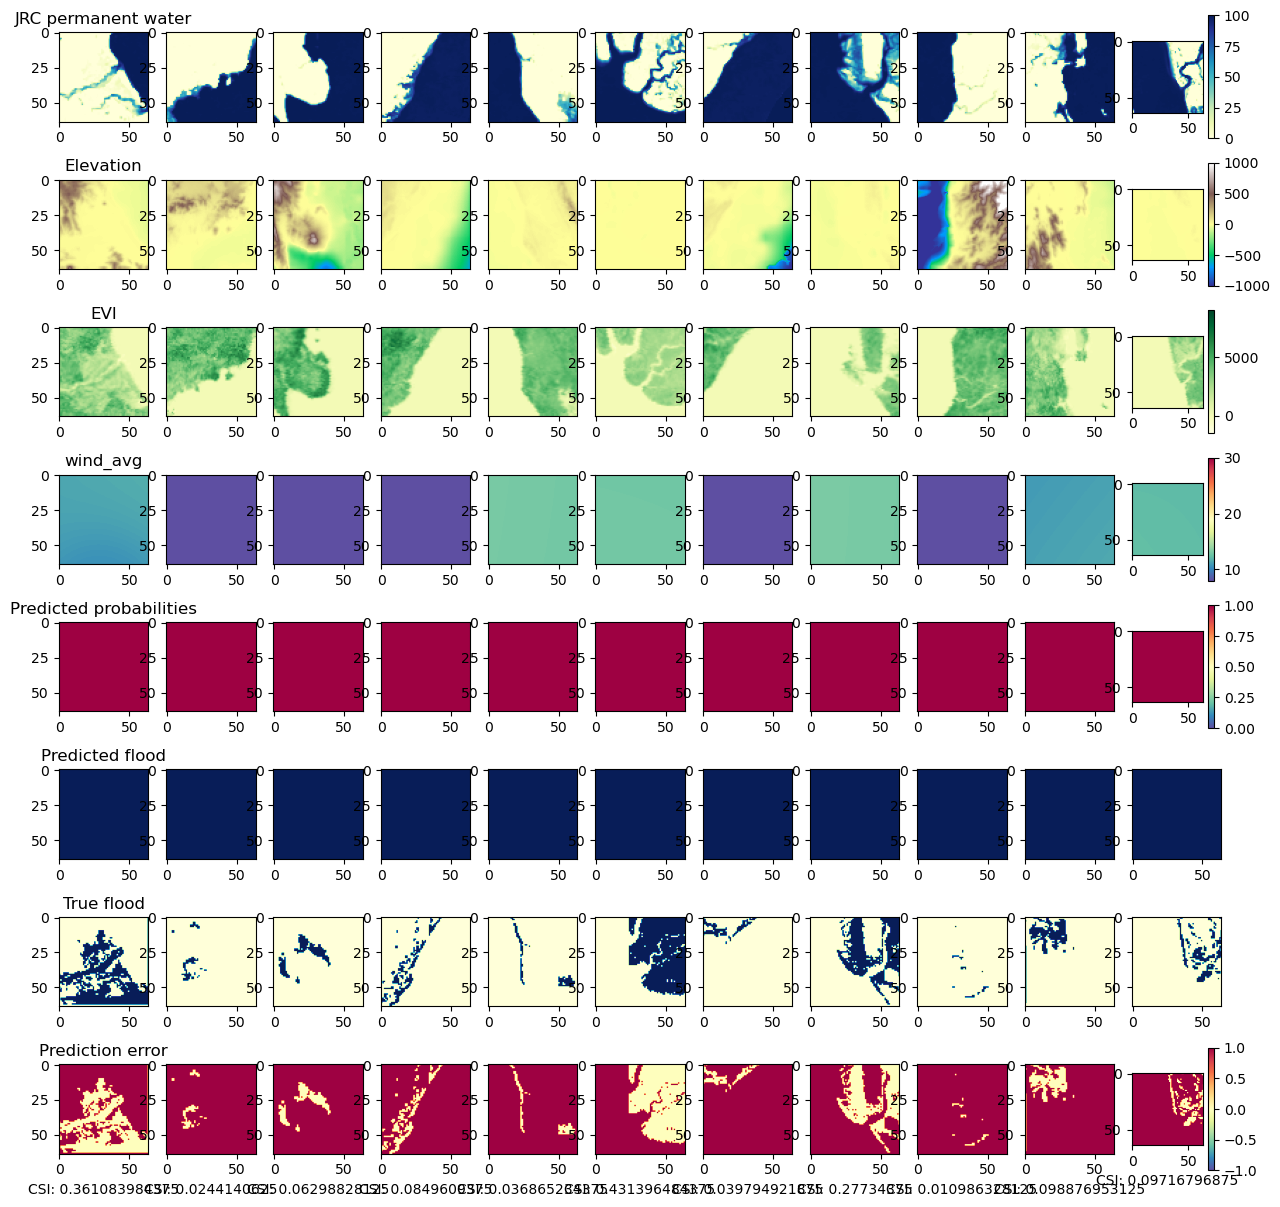

In [58]:
# plot results on the test set
viz = True

if viz:
    fig, axs = plt.subplots(8, len(X_test), figsize=(15, 15))

    ax = axs[0, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['jrc_permwa']
        cmap, _, _ = viz_utils.cmap_key['jrc_permwa']
        vmin, vmax = viz_utils.cmap_range['jrc_permwa']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("JRC permanent water")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[1, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['elevation']
        cmap, _, _ = viz_utils.cmap_key['elevation']
        vmin, vmax = viz_utils.cmap_range['elevation']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("Elevation")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[2, :]
    for i, pred in enumerate(X_test):
        fi = feature_key_r['evi']
        cmap, _, _ = viz_utils.cmap_key['evi']
        vmin, vmax = viz_utils.cmap_range['evi']
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("EVI")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    
    ax = axs[3, :]
    for i, pred in enumerate(X_test):
        wind_var = 'wind_avg'
        fi = feature_key_r[wind_var]
        cmap, _, _ = viz_utils.cmap_key[wind_var]
        vmin, vmax = viz_utils.cmap_range[wind_var]
        im = ax[i].imshow(pred[:, :, fi], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title(wind_var)
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[4, :]
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r", vmin=0, vmax=1)
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    ax = axs[5, :]
    for i, pred in enumerate(y_pred):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=1)
    ax[0].set_title("Predicted flood")
        
    ax = axs[6, :]
    for i, pred in enumerate(y_test):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=1)
    ax[0].set_title("True flood")
    
    ax = axs[7, :]
    for i, x in enumerate(zip(y_pred, y_test)):
        pred, true = x[0], x[1]
        CSI.reset_state()
        CSI.update_state(true, pred)
        csi_i = CSI.result().numpy()
        
        err = (pred.reshape(64, 64) == true.reshape(64, 64)).astype(float)
        diff = pred.reshape(64, 64) - true.reshape(64, 64)
        
        im = ax[i].imshow(diff, cmap="Spectral_r", vmin=-1, vmax=1)
        ax[i].set_xlabel(f"CSI: {csi_i}")
    ax[0].set_title("Prediction error")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    outfile = join(imdir, "unet", "unet_results.png")
                     
    # fig.savefig(outfile, bbox_inches="tight")